In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [4]:
data = pd.read_csv("NLP Project Work/eng_train.txt", encoding="utf-8", sep=" ", header=None, skip_blank_lines=False)

In [5]:
test_df = pd.read_csv("NLP Project Work/Datasets/Articles.csv", encoding='latin1')
test_df.columns = ["text","date","headline","label"]

In [ ]:
test_df.head()

,text,date,headline,label
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


In [6]:
data.columns = ["Word", "POS", "IOB tags", "Tag"]
data.head(10)
set(data["Tag"])

{'B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O', nan}

In [ ]:
# if math.isnan(data["Word"][9]):
#   print("f")

In [7]:
# add a new column "sentence", seperating rows by empty lines
i = 0
sentence_list = []
for row in data["Word"]:
  if isinstance(row, str):
    sentence_list.append(str(i))
  else:
    i += 1
    sentence_list.append(float('nan'))

In [8]:
data["Sentence"] = sentence_list
data = data.dropna()
data.head(10)

,Word,POS,IOB tags,Tag,Sentence
0,EU,NNP,I-NP,I-ORG,0
1,rejects,VBZ,I-VP,O,0
2,German,JJ,I-NP,I-MISC,0
3,call,NN,I-NP,O,0
4,to,TO,I-VP,O,0
5,boycott,VB,I-VP,O,0
6,British,JJ,I-NP,I-MISC,0
7,lamb,NN,I-NP,O,0
8,.,.,O,O,0
10,Peter,NNP,I-NP,I-PER,1


In [9]:
class SentenceGetter(object):

  def __init__(self, data):
    self.n_sent = 1
    self.data = data
    self.empty = False
    agg_func = lambda s: [(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),s["POS"].values.tolist(),s["Tag"].values.tolist())]
    self.grouped = self.data.groupby("Sentence").apply(agg_func)
    self.sentences = [s for s in self.grouped]

  def get_next(self):
    try:
      s = self.grouped["Sentence: {}".format(self.n_sent)]
      self.n_sent += 1
      return s
    except:
      return None


In [10]:
getter = SentenceGetter(data)

In [11]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [12]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']


In [13]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
# APPLY BERT

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
%pip install transformers
from transformers import BertTokenizer, BertConfig

%pip install tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

In [15]:
MAX_LEN = 75
bs = 32

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [17]:
torch.cuda.get_device_name(0)

'A100-SXM4-40GB'

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
def tokenize_and_preserve_labels(sentence, text_labels):
  tokenized_sentence = []
  labels = []
  for word, label in zip(sentence, text_labels):

    # Tokenize the word and count # of subwords the word is broken into
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)

    # Add the tokenized word to the final tokenized word list
    tokenized_sentence.extend(tokenized_word)

    # Add the same label to the new list of labels `n_subwords` times
    labels.extend([label] * n_subwords)
    
  return tokenized_sentence, labels

In [20]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [21]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [22]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [23]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [24]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [25]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [26]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [27]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [ ]:
#  Setup the Bert model for finetuning

In [28]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.24.0'

In [29]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [30]:
model.cuda();


In [31]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
# Fit BERT for named entity recognition

In [33]:
%pip install seqeval
from seqeval.metrics import f1_score, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 46 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=e86f6c597f0eccf228a796c7c34343157146a96834c719e6c6a0f11fdb6cb8f0
  Stored in directory: /root/.cache/pip/wheels/ad/5c/ba/05fa33fa5855777b7d686e843ec07452f22a66a138e290e732
Successfully built seqeval


In [35]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
validation_accuracy = []
f1_scores = []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    validation_accuracy.append(accuracy_score(pred_tags, valid_tags))
    # print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    # f1_scores.append(f1_score(pred_tags, valid_tags))

    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.01474188978262952


Epoch:  33%|███▎      | 1/3 [00:50<01:40, 50.22s/it]

Validation loss: 0.016845237882312465
Validation Accuracy: 0.9833448489035965

Average train loss: 0.008658344300008065


Epoch:  67%|██████▋   | 2/3 [01:40<00:50, 50.18s/it]

Validation loss: 0.016233264741071677
Validation Accuracy: 0.9841448779955635

Average train loss: 0.006938003676019882


Epoch: 100%|██████████| 3/3 [02:30<00:00, 50.20s/it]

Validation loss: 0.016233264741071677
Validation Accuracy: 0.9841448779955635



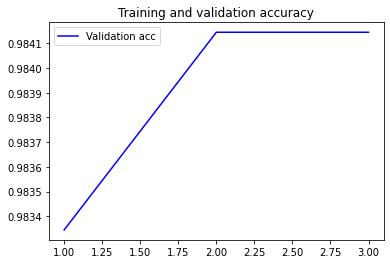

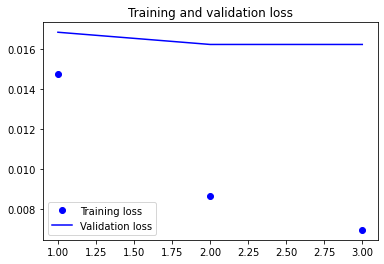

In [36]:
import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# validation_accuracy = []
epochs = range(1, 4)

plt.plot(epochs, validation_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, validation_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# loss visualization

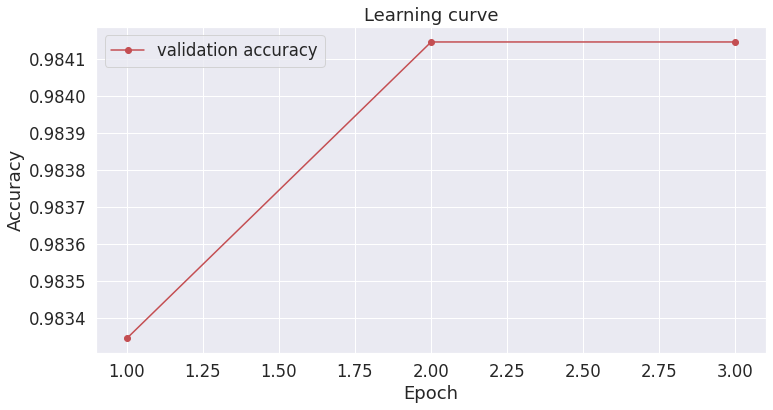

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
# plt.plot(epochs, 'b-o', label="training loss")
plt.plot(epochs, validation_accuracy, 'r-o', label="validation accuracy")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

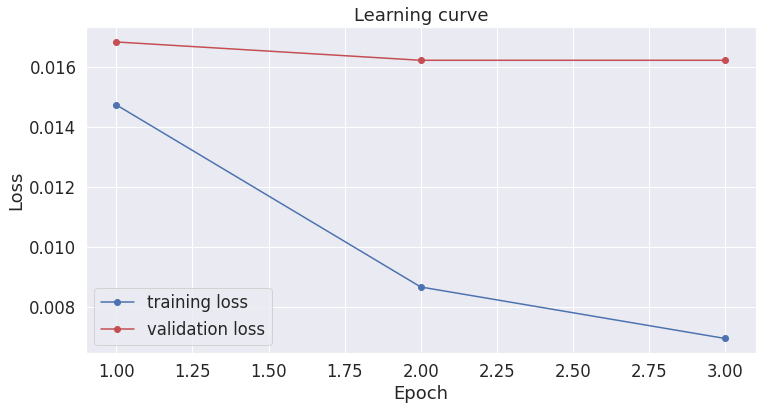

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(epochs, loss_values, 'b-o', label="training loss")
plt.plot(epochs, validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
# import pickle
# filename = 'dataset/nlp_project/model.sav'
# pickle.dump(model, open(filename, 'wb'))
  
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
#paths = 'dataset/nlp_project/model3.pt'

In [ ]:
#loaded_model3 = torch.load(paths)

# Apply the model to a new sentence

In [42]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""

In [43]:
def test_func(test_sentence):
  tokenized_sentence = tokenizer.encode(test_sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  ner_tokens = []
  ner = []

  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
  # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
      new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
      new_labels.append(tag_values[label_idx])
      new_tokens.append(token)
      
  for token, label in zip(new_tokens, new_labels):
    #print("{}\t{}".format(label, token))
    if label in ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER']:
      ner_tokens.append(label)
      ner.append(token)
      
  return ner_tokens, ner

In [44]:
test_func(test_sentence)

(['I-PER', 'I-ORG', 'I-ORG', 'I-PER', 'I-PER', 'I-LOC'],
 ['Trump', 'Fox', 'News', 'Mike', 'Tobin', 'Minnesota'])

In [ ]:
test_df.head()

,text,date,heading,label
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


In [46]:
pd.read_csv()

(['I-ORG', 'I-LOC', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-PER', 'I-PER', 'I-LOC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-PER', 'I-LOC', 'I-MISC'], ['KARACHI', 'Sindh', 'Geo', 'News', 'Karachi', 'Transport', 'Ittehad', 'KTI', 'KTI', 'Irshad', 'Bukhari', 'Karachi', 'Compressed', 'Natural', 'Gas', 'CNG', 'Bukhari', 'Karachi', 'CNG'])


In [ ]:
# delete dirty rows
count = 0
for i in range(len(test_df)):
  try:
    test_func(test_df['text'][i])
    count += 1
  except:
    test_df = test_df.drop(i)

In [ ]:
len(test_df)

1973

In [ ]:
# check label balance
test_df['label'].value_counts()

sports      1085
business     888
Name: label, dtype: int64

In [ ]:
1085/1973

0.5499239736441967

In [ ]:
test_df = test_df.reset_index()
test_df = test_df.drop('index',axis=1)

In [ ]:
tokens, labels = [], []

df = test_df[~pd.isnull(test_df['text'])]

for i in range(df.shape[0]):
  test_sentence = df["text"].iloc[i]
  try:
    ner_labels, ner_tokens = test_func(test_sentence)
  except:
    print(test_func(test_sentence))
  tokens.append(ner_tokens); labels.append(ner_labels)

df['ner'] = tokens
df['ner_labels'] = labels

In [ ]:
df.to_csv('NLP Project Work/entitied_article.csv')

In [ ]:
pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 1.3 MB 17.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=b092ff11217f15d70a98de9cd06869c79dd745e7f13ac729b0c7c7e62d2b2e10
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
# # Self-trained embedding
# from gensim.test.utils import common_texts
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# from sklearn.model_selection import train_test_split
# train, test = train_test_split(df)

# train['text'] = [TaggedDocument(x, [i]) for i, x in enumerate(train['text'])]
# d2v_model = Doc2Vec(vector_size = 96, min_count = 2, epochs = 40)
# d2v_model.build_vocab(train['text'])

# d2v_model.train(train['text'], total_examples = d2v_model.corpus_count, epochs = d2v_model.epochs)

# vector = d2v_model.infer_vector(['Joe','Biden','eats','pineapples'])
# vector

# !pip3 install --upgrade gensim --user

# print(f"Word 'penalty' appeared {model.wv.get_vecattr('Biden', 'count')} times in the training corpus.")

In [ ]:
k = list()
for i in range(len(df['ner'])):
  k.append(' '.join(df['ner'][i]))
df['connected_ner']=k

In [ ]:
# Pre-trained embedding space
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = df['connected_ner']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [ ]:
pretrain_embeddings = pd.DataFrame(embeddings)
pretrain_embeddings.to_csv('NLP Project Work/pretrain_embeddings.csv')

In [ ]:
l = []
for i in range(df.shape[0]):
  l.append(d2v_model.infer_vector(df["ner"].iloc[i]))
vector_df = pd.DataFrame(l)
# vector_df.columns = ["x1", "x2"]
# vector_df["label"] = test_df["label"]

In [ ]:
vector_df.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.000532,0.000311,0.000189,0.003604,0.002065,-0.003308,0.003440,0.001356,0.004900,0.004083,...,-0.002516,-0.005122,-0.003659,0.001429,0.000412,0.002395,0.003518,0.001660,0.002981,0.000083
1,-0.002709,0.004573,0.002921,-0.004413,-0.002079,-0.003485,0.003474,-0.004722,-0.000596,-0.003004,...,-0.000668,0.000416,-0.000511,0.001019,0.000818,-0.002553,-0.001619,0.001707,-0.001410,0.003643
2,0.003464,0.002077,-0.003448,0.001061,-0.004815,-0.000603,0.000343,0.003660,0.000461,-0.003110,...,0.002412,-0.000105,-0.003589,0.004755,0.003932,0.002069,0.000213,0.003670,0.000018,-0.003974
3,0.007674,-0.096131,0.089179,-0.132919,-0.119575,-0.135286,0.049296,0.090631,-0.029554,-0.073430,...,-0.205182,0.054428,-0.099262,0.074364,-0.081397,0.141881,-0.117577,0.036985,0.110409,-0.092651
4,-0.000609,-0.000865,0.000054,0.004889,-0.002626,-0.003451,-0.004242,-0.000922,-0.004517,0.003120,...,-0.004156,-0.003811,-0.001126,-0.002936,0.001447,-0.000532,-0.000450,0.002648,-0.001172,0.004747


In [ ]:
#PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# pca_result = pca.fit_transform(vector_df)
pca_result = pca.fit_transform(pretrain_embeddings)
pca_result

array([[ 0.3733449 , -0.15820661],
       [ 0.26692605,  0.16504048],
       [ 0.3083826 ,  0.17813557],
       ...,
       [ 0.16085553, -0.08090244],
       [ 0.12843275,  0.3015418 ],
       [ 0.27747422,  0.01266385]], dtype=float32)

In [ ]:
pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca_1", "pca_2"]
pca_df["label"] = test_df["label"]
pca_df.shape

(1973, 3)

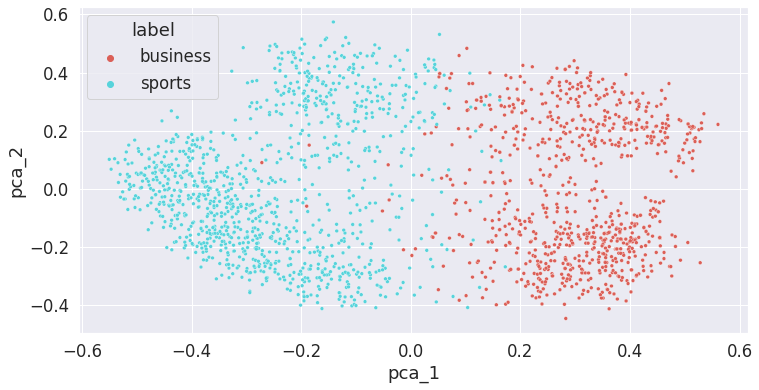

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.scatterplot(
    x="pca_1", y="pca_2",
    hue="label",
    palette=sns.color_palette("hls",2),
    data=pca_df,
    legend="full",
    #alpha=0.7,
    s = 14,
    ax=ax
)
# ax.set_xlim(-0.1, -0.04)
# ax.set_ylim(-0.02, 0.04)
plt.show()

In [ ]:
# set(test_df["label"])

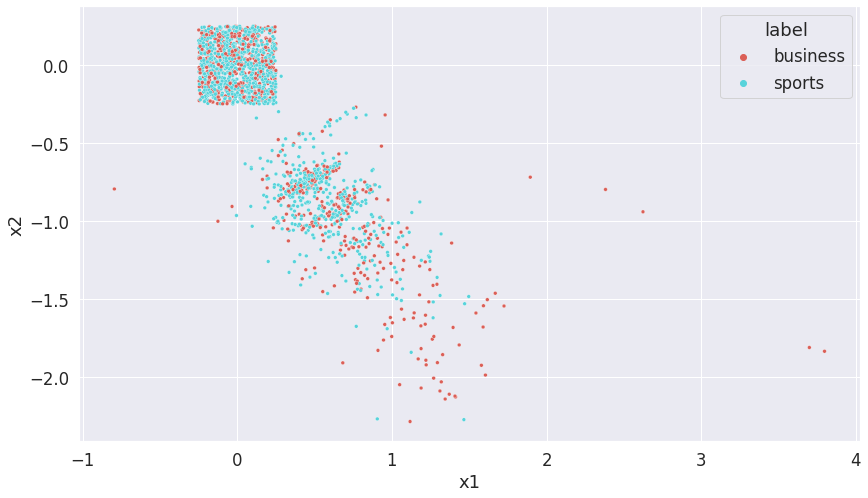

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(14,8))
# sns.scatterplot(
#     x="x1", y="x2",
#     hue="label",
#     palette=sns.color_palette("hls",2),
#     data=vector_df,
#     legend="full",
#     #alpha=0.7,
#     s = 14
# )

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="x1", y="x2",
#     hue="label",
#     palette=sns.color_palette("hls",8),
#     data=vector_df,
#     legend="full",
#     #alpha=0.7,
#     s = 14
# )